In [1]:
import torch
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import numpy as np

In [2]:
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

In [3]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)

In [4]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = self.linear(x)
        return outputs

In [6]:
batch_size = 100
epochs = 30
input_dim = 784
output_dim = 10
lr_rate = 0.05
len_train_dataset = len(train_loader.dataset)

In [7]:
def get_alt_model_loss(x, y, model, alt_model, criterion, w_set):
    alt_losses = []
    
    for w_reshape in w_set:
        for param, alt_param, w in zip(model.parameters(), alt_model.parameters(), w_reshape):
            alt_param.data = param.data - lr_rate * (1 + w.data) * param.grad.data
            #alt_param.data = param.data - lr_rate * (1) * param.grad.data

        alt_outputs = alt_model(x)
        alt_loss = criterion(alt_outputs, y)

        alt_losses.append(alt_loss)

    return torch.tensor(alt_losses)

In [8]:
model = LogisticRegression(input_dim, output_dim).cuda()
alt_model = LogisticRegression(input_dim, output_dim).cuda()
criterion = torch.nn.CrossEntropyLoss().cuda()

w_dim = sum([param.shape.numel() for param in model.parameters()])

In [9]:
z_dim = 4
A = (2 * torch.rand([w_dim, z_dim]) - 1) / (z_dim / 4)
z_length = 50
z = torch.rand([z_dim, z_length])

def seperate_w(w, model):
    w_reshape_list = []
    num_params = 0
    for param in model.parameters():
        w_reshape = w[num_params:num_params + param.shape.numel()].reshape_as(param)
        w_reshape_list.append(w_reshape)
        num_params += param.shape.numel()
    
    return w_reshape_list

def get_w_set(Az, model):
    w_set = [seperate_w(Az[:, i].cuda(), model) for i in range(Az.shape[1])]
    return w_set

w_set = get_w_set(A.mm(z).clamp(min=-0.9), model)

init_w = [torch.zeros(w.shape).cuda() for w in w_set[0]]

best_w = init_w

In [10]:
def show_params(model):
    for param in model.parameters():
        print(param.data)

In [11]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import qUpperConfidenceBound
from botorch.optim import optimize_acqf

def get_next_z_set_and_best_z(z, increments):
    train_X = z.T.cpu().clone().data
    train_Y = increments.reshape([-1, 1]).clone().data

    gp = SingleTaskGP(train_X, train_Y)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll)

    qUCB = qUpperConfidenceBound(gp, beta=0.1)

    bounds = torch.stack([torch.zeros(4), torch.ones(4)])
    candidates, acq_value = optimize_acqf(
        qUCB, bounds=bounds, q=50, num_restarts=20, raw_samples=512,
    )
    print("increment : {0:.7f}".format(increments.max().item()))
    return candidates, z.T[increments.argmax()]

In [12]:
results = []
for epoch in range(epochs):
    avg_loss = 0.
    
    increments = torch.zeros(z_length)
    
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, 28 * 28)).cuda()
        labels = Variable(labels).cuda()
        
        outputs = model(images)
        loss = criterion(outputs, labels)

        model.zero_grad()
        loss.backward()
        
        avg_loss += loss / (len_train_dataset / batch_size)
        
        with torch.no_grad():
            alt_losses = get_alt_model_loss(images, labels, model, alt_model, criterion, w_set)
            #show_params(alt_model)
            for w, param in zip(best_w, model.parameters()):
                param.data -= lr_rate * (1 + w.data) * param.grad.data
        
        with torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, labels)
            #show_params(model)
        
        #print(loss, alt_losses)
        increments += (loss.cpu() - alt_losses) / (len_train_dataset / batch_size)
        
        #print(alt_losses)
    results.append(avg_loss)
    
    z_set, best_z = get_next_z_set_and_best_z(z, increments)
    w_set = get_w_set(A.mm(z_set.T).clamp(min=-0.9), model)
    best_w = get_w_set(A.mm(best_z.reshape([-1, 1])).clamp(min=-0.9), model)[0]
    
    print(epoch, avg_loss.data)
    

C:\Users\Samsung\Anaconda2\envs\tf\lib\site-packages\gpytorch\utils\cholesky.py:42: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


increment : 0.0014180
0 tensor(0.6582, device='cuda:0')
increment : 0.0003770
1 tensor(0.4060, device='cuda:0')


C:\Users\Samsung\Anaconda2\envs\tf\lib\site-packages\gpytorch\utils\cholesky.py:42: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


increment : 0.0008743
2 tensor(0.3663, device='cuda:0')


C:\Users\Samsung\Anaconda2\envs\tf\lib\site-packages\gpytorch\utils\cholesky.py:42: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


increment : 0.0009732
3 tensor(0.3466, device='cuda:0')


C:\Users\Samsung\Anaconda2\envs\tf\lib\site-packages\gpytorch\utils\cholesky.py:42: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


increment : 0.0006287
4 tensor(0.3339, device='cuda:0')
increment : 0.0009145
5 tensor(0.3246, device='cuda:0')


C:\Users\Samsung\Anaconda2\envs\tf\lib\site-packages\gpytorch\utils\cholesky.py:42: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


increment : 0.0008106
6 tensor(0.3176, device='cuda:0')


C:\Users\Samsung\Anaconda2\envs\tf\lib\site-packages\gpytorch\utils\cholesky.py:42: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


increment : 0.0008059
7 tensor(0.3120, device='cuda:0')


C:\Users\Samsung\Anaconda2\envs\tf\lib\site-packages\gpytorch\utils\cholesky.py:42: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


increment : 0.0009599
8 tensor(0.3074, device='cuda:0')


C:\Users\Samsung\Anaconda2\envs\tf\lib\site-packages\gpytorch\utils\cholesky.py:42: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


increment : 0.0007889
9 tensor(0.3036, device='cuda:0')
increment : 0.0009344
10 tensor(0.3003, device='cuda:0')


C:\Users\Samsung\Anaconda2\envs\tf\lib\site-packages\gpytorch\utils\cholesky.py:42: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


increment : 0.0005988
11 tensor(0.2974, device='cuda:0')


C:\Users\Samsung\Anaconda2\envs\tf\lib\site-packages\gpytorch\utils\cholesky.py:42: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


increment : 0.0007428
12 tensor(0.2949, device='cuda:0')


C:\Users\Samsung\Anaconda2\envs\tf\lib\site-packages\gpytorch\utils\cholesky.py:42: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


increment : 0.0009037
13 tensor(0.2926, device='cuda:0')


C:\Users\Samsung\Anaconda2\envs\tf\lib\site-packages\gpytorch\utils\cholesky.py:42: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


increment : 0.0006207
14 tensor(0.2906, device='cuda:0')
increment : 0.0006577
15 tensor(0.2887, device='cuda:0')


C:\Users\Samsung\Anaconda2\envs\tf\lib\site-packages\gpytorch\utils\cholesky.py:42: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


increment : 0.0007027
16 tensor(0.2870, device='cuda:0')


C:\Users\Samsung\Anaconda2\envs\tf\lib\site-packages\gpytorch\utils\cholesky.py:42: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


increment : 0.0006910
17 tensor(0.2855, device='cuda:0')


C:\Users\Samsung\Anaconda2\envs\tf\lib\site-packages\gpytorch\utils\cholesky.py:42: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


increment : 0.0008884
18 tensor(0.2840, device='cuda:0')


C:\Users\Samsung\Anaconda2\envs\tf\lib\site-packages\gpytorch\utils\cholesky.py:42: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


increment : 0.0007140
19 tensor(0.2827, device='cuda:0')


C:\Users\Samsung\Anaconda2\envs\tf\lib\site-packages\gpytorch\utils\cholesky.py:42: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


increment : 0.0008529
20 tensor(0.2815, device='cuda:0')


C:\Users\Samsung\Anaconda2\envs\tf\lib\site-packages\gpytorch\utils\cholesky.py:42: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


increment : 0.0006391
21 tensor(0.2804, device='cuda:0')
increment : 0.0006983
22 tensor(0.2793, device='cuda:0')
increment : 0.0007433
23 tensor(0.2783, device='cuda:0')


C:\Users\Samsung\Anaconda2\envs\tf\lib\site-packages\gpytorch\utils\cholesky.py:42: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


increment : 0.0006349
24 tensor(0.2773, device='cuda:0')


C:\Users\Samsung\Anaconda2\envs\tf\lib\site-packages\gpytorch\utils\cholesky.py:42: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


increment : 0.0006304
25 tensor(0.2765, device='cuda:0')


C:\Users\Samsung\Anaconda2\envs\tf\lib\site-packages\gpytorch\utils\cholesky.py:42: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


increment : 0.0003627
26 tensor(0.2757, device='cuda:0')
increment : 0.0006879
27 tensor(0.2748, device='cuda:0')
increment : 0.0001444
28 tensor(0.2742, device='cuda:0')


C:\Users\Samsung\Anaconda2\envs\tf\lib\site-packages\gpytorch\utils\cholesky.py:42: RuntimeWarning: A not p.d., added jitter of 1e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


increment : 0.0007406
29 tensor(0.2733, device='cuda:0')


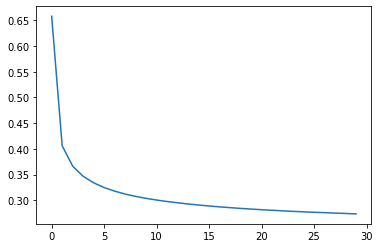

In [14]:
import matplotlib.pyplot as plt

plt.plot(results)

In [ ]:
correct = 0.
total = 0.

for images, labels in test_loader:
    images = Variable(images.view(-1, 28*28)).cuda()
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct+= (predicted.cpu() == labels).sum()

accuracy = 100 * correct.float() / total

In [ ]:
accuracy